In [92]:
import numpy as np
import matplotlib.pyplot as plt
import preprocessing as pp
import implementations as imp

# Import Data Sets


In [93]:
path="/Users/leocusumano/myCloud/EPFL/MA1/ML/Proj1/DATASETS/f_sets/"

x_train=np.load(path+"f_x_train_.npy")
x_test=np.load(path+"f_x_test_.npy")
y_train=np.load(path+"f_y_train_.npy")
test_ids=np.load(path+"f_test_ids_.npy")
train_ids=np.load(path+"f_train_ids_.npy")


In [94]:

x1,x1_t,y=pp.Edited_clean_data(x_train,y_train,x_test,correlation_thr=.95,nan_thr=.4,std_thr=0.1)
#important to add a constant term for the bias
x=np.concatenate((x1,np.zeros((x1.shape[0],1))+1),axis=1)
x_t=np.concatenate((x1_t,np.zeros((x1_t.shape[0],1))+1),axis=1)

assert x1.shape[1]+1==x.shape[1]

y_=np.where(y==-1,0,1)
y_=y_.astype(int)

X,Y,X_T,Y_T=pp.split_data(x,y_,.5)


Max median NaN score rows :  0.5688708393430034
Max median NaN score columns :  0.7598051755967697
Number of rows dropped because of a NaN score > 0.4:  326420
Number of columns dropped because of a NaN score > 0.4:  177
Number of columns with std < 0.1: 2
Number of columns with correl_coef > 0.95: 21
Handling NaN values...
Number of columns with corr_coef> 0.95 after cleaning: 2
The data has been cleaned and standardized
The cleaned x-data has the following shape:  (1715, 119)
The cleaned y-data has the following shape:  (1715,)
The cleaned x-data-to-predict has the following shape:  (109379, 119)


# Logistic

In [95]:
param_grid = {
    "max_iters": [1500],
    "gamma": [1,0.1, 0.001],
    "lambda_": [1e-4,1e-5,1e-6],
}

In [96]:
best_params_log = None
best_score_log = float("inf")
w_initial = np.zeros(X.shape[1])
best_w_log = w_initial
logs=[]
for max_iters in param_grid["max_iters"]:
    for gamma in param_grid["gamma"]:
        for lam in param_grid["lambda_"]:
                w, loss,losses = imp.reg_logistic_regression(Y, X,lam, w_initial, max_iters, gamma,True)
                print("Loss:", loss)
                logs.append({"loss": loss, "max_iters": max_iters, "gamma": gamma,"losses":losses, "lambda_": lam})
                if loss < best_score_log:
                    best_score_log = loss
                    best_w_log = w
                    best_params_log = {
                        "max_iters": max_iters,
                        "gamma": gamma,
                        "lambda_": lam
                    }

losses_ar=np.array([a["losses"] for a in logs])               
                  
print("Best hyperparameters found: ", best_params_log)

Loss: 0.30642706301894085
Loss: 0.3057703138485999
Loss: 0.30570640562641815
Loss: 0.31662507416098756
Loss: 0.3164382622778468
Loss: 0.3164197607503575
Loss: 0.44081000044292484
Loss: 0.44079917279663455
Loss: 0.44079809004266746
Best hyperparameters found:  {'max_iters': 1500, 'gamma': 1, 'lambda_': 1e-06}


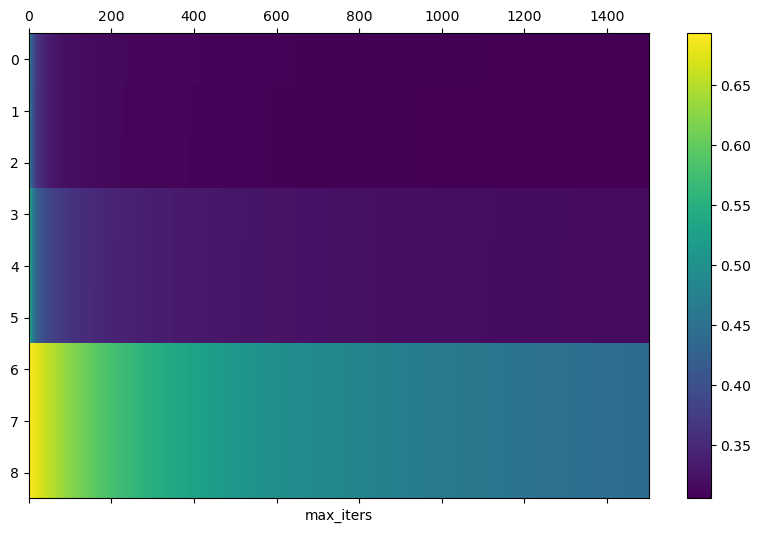

Best loss: 0.30570640562641815
Best iterations  1500
Best gamma  0.001
Best lambda  1e-06


<Figure size 3000x1800 with 0 Axes>

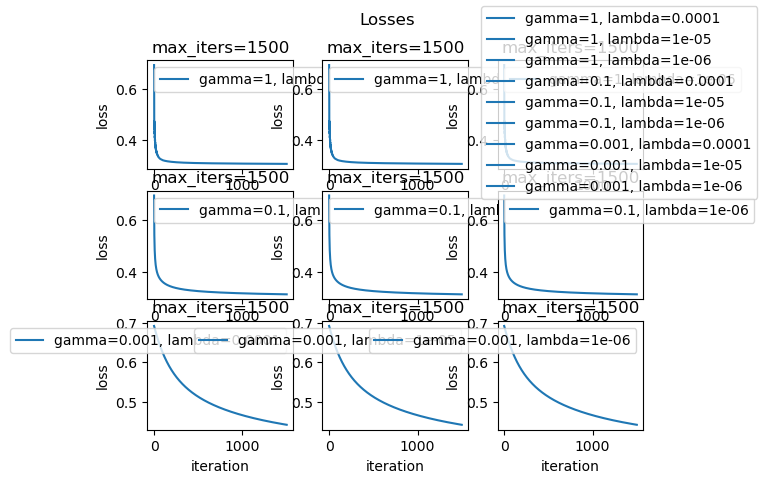

In [97]:
plt.figure(figsize=(10, 6))
plt.matshow(losses_ar, fignum=1, aspect='auto')
plt.xlabel("max_iters")
plt.colorbar()
plt.show()

plt.figure(figsize=(30, 18))
_,a=plt.subplots(3,3)
_.suptitle("Losses")
for i in range(9):
    a[i//3,i%3].plot(logs[i]["losses"],label="gamma="+str(logs[i]["gamma"])+", lambda="+str(logs[i]["lambda_"]))
    a[i//3,i%3].set_title("max_iters="+str(logs[i]["max_iters"]))
    a[i//3,i%3].set_xlabel("iteration")
    a[i//3,i%3].set_ylabel("loss")
    a[i//3,i%3].legend()
_.legend()
minlo=np.min(losses_ar[losses_ar>0])
best_iter=np.where(losses_ar==minlo)
print("Best loss:",minlo)
print("Best iterations ",best_iter[1][0])
print("Best gamma ",param_grid["gamma"][best_iter[0][0]])
print("Best lambda ",param_grid["lambda_"][best_iter[0][0]])

In [98]:

w_tot, loss_tot,losses = imp.reg_logistic_regression(y_, x,1e-6, np.zeros(x.shape[1]), 1700,0.01,True)
loss_tot

0.3564405534505789

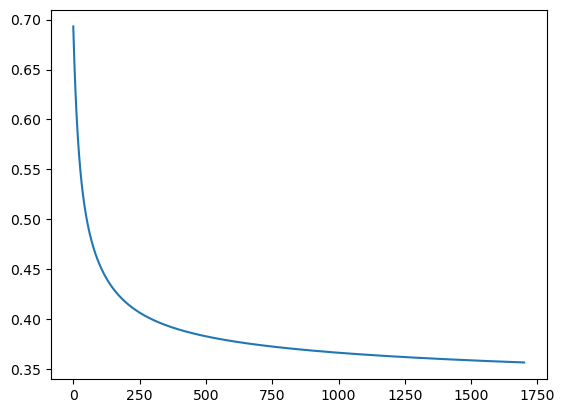

In [99]:
losses_n=np.array(losses)
plt.plot(losses_n)

In [106]:
from sklearn.metrics import f1_score,accuracy_score,roc_curve

# Compute the predicted probabilities
y_pred_proba = imp.sigmoid(X_T @ w_tot)

# Search for the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []
for threshold in thresholds:
    y_pred_log = np.where(y_pred_proba > threshold, 1, -1)
    Y_T_=np.where(Y_T==0,-1,1)
    f1 = f1_score(Y_T_, y_pred_log)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold based on F1 score:", optimal_threshold, "F1 score:", np.max(f1_scores))
print("Accuracy:", accuracy_score(Y_T_, np.where(y_pred_proba > optimal_threshold, 1, -1)))



Optimal Threshold based on F1 score: 0.2 F1 score: 0.5147058823529412
Accuracy: 0.7692307692307693


best
Optimal Threshold based on F1 score: 0.63 F1 score: 0.4071666487589986
Accuracy: 0.8654821948283481


In [101]:
import helpers as hlp


In [102]:
y_sub = imp.sigmoid(x_t @ w_tot)
y_sub = np.where(y_sub > optimal_threshold, 1, -1)

hlp.create_csv_submission(test_ids, y_sub, "/Users/leocusumano/myCloud/EPFL/MA1/ML/Proj1/DATASETS/y_pred_logg.csv")

